In [53]:
from ccb import io
import pandas as pd
from ccb.dataset_converters import inspect_tools
from ccb import io
from tqdm import tqdm
import numpy as np
from ccb.dataset_converters import inspect_tools
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:

def collect_task_info(task):
    loss = task.eval_loss
    if isinstance(loss, type):
        loss = loss()
    try:
        dataset = task.get_dataset('train')
        partition = dataset.active_partition.partition_dict
        n_train = len(partition["train"])
        n_valid = len(partition["valid"])
        n_test = len(partition["test"])
    except Exception as e:
        print(e)
        n_train, n_valid, n_test = -1, -1, -1
    
    n_classes = getattr(task.label_type, "n_classes", -1)

    task_dict = {
        'name': task.dataset_name,
        'img size': ' x '.join([ str(size) for size in task.patch_size]),
        'loss': str(loss),
        'label type': task.label_type.__class__.__name__,
        'n classes': int(n_classes),
        'n time steps': task.n_time_steps,
        'n train' : n_train,
        'n valid' : n_valid,
        'n test' : n_test,
    }
    task_dict.update(inspect_tools.summarize_band_info(task.bands_info))
    return task_dict, dataset

def collect_benchmark_info(benchmark_name):

    data = []
    for task in io.task_iterator(benchmark_name):
        print(task.dataset_name)

        task_dict, _ = collect_task_info(task)
        data.append(task_dict)
    return data



Task: eurosat
sizes: train=3000.
RGB Shape: 64 x 64 


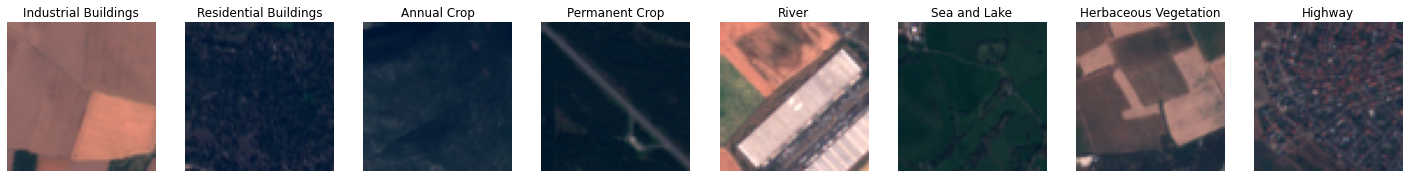

Task: brick_kiln_v1.0
sizes: train=3000.
RGB Shape: 64 x 64 


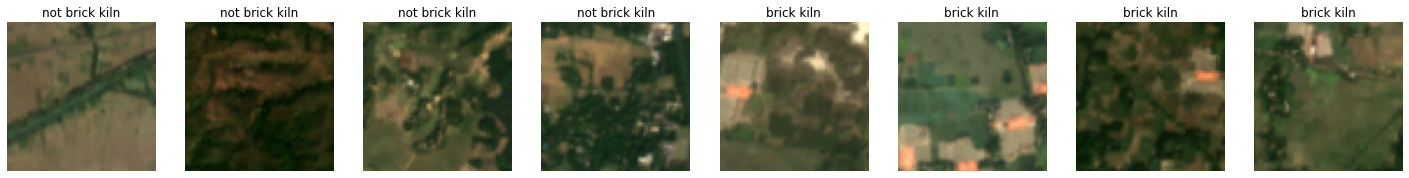

Task: so2sat
sizes: train=2992.
RGB Shape: 32 x 32 


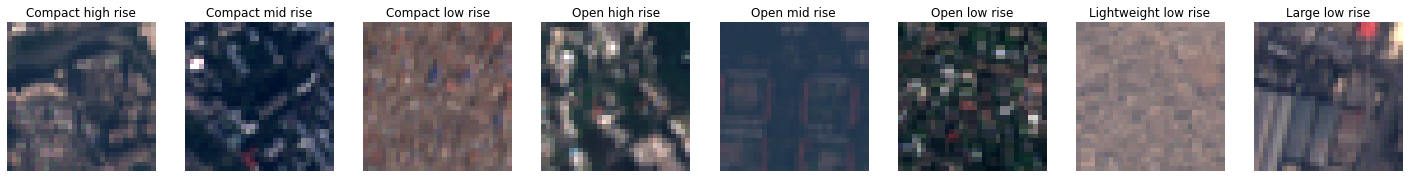

Task: pv4ger_classification
sizes: train=3000.
RGB Shape: 320 x 320 


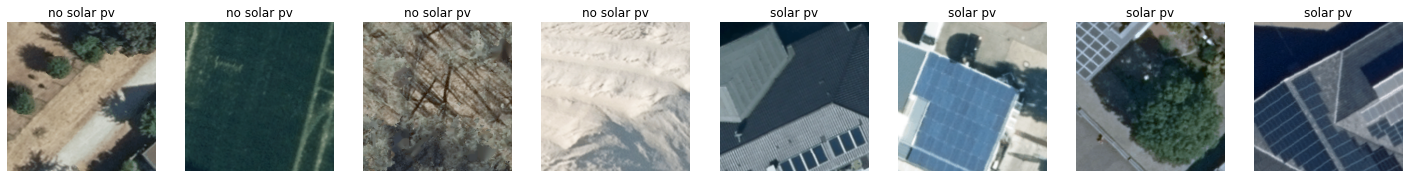

Task: bigearthnet
sizes: train=3000.
RGB Shape: 120 x 120 


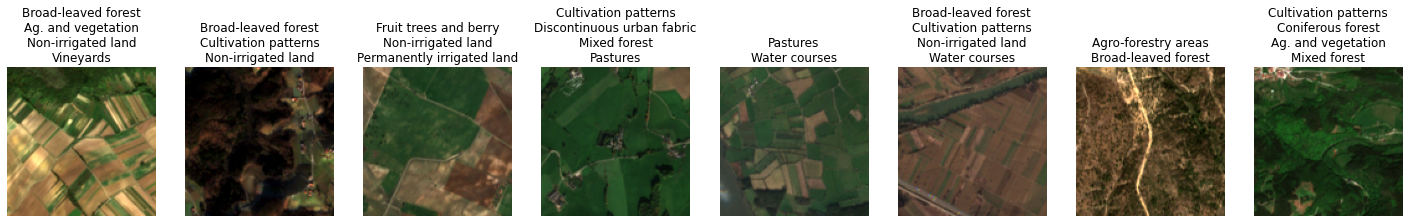

In [55]:
def extract_classification_samples(dataset: io.Dataset, num_samples=8, rng=np.random):
    label_map = dataset.task_specs.get_label_map()
    n_classes = len(label_map)
    n_per_class = np.ceil(num_samples / n_classes)
    samples = []
    for label, names in label_map.items():
        for sample_name in rng.choice(names, size=int(n_per_class), replace=False):
            samples.append(dataset.get_sample(sample_name))
    return samples[:num_samples]

def plot_images(images, names):
    fig, axs = plt.subplots(1,len(images))
    for image, name, ax in zip(images, names, axs):
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(name)
    plt.show()

def replace_str(name):
    replace_dict = {
        "Land principally occupied by agriculture, with significant areas of natural vegetation": "Ag. and vegetation",
        "Non-irrigated arable land": "Non-irrigated land",
        "Complex cultivation patterns": "Cultivation patterns",
        "Fruit trees and berry plantations": "Fruit trees and berry"}
    for key, val in replace_dict.items():
        name = name.replace(key, val)
    return name

for task in io.task_iterator("classification_v0.4"):
    task_info, _ = collect_task_info(task)

    print(f"Task: {task.dataset_name}")
    print(f"sizes: train={task_info['n train']}.")
    print(f"RGB Shape: {task_info['img size']} ")

    dataset = task.get_dataset(split="train")
    
    if not isinstance(task.label_type, io.label.MultiLabelClassification):
        samples = extract_classification_samples(dataset)
    else:
        samples = [dataset[i] for i in range(8)]

    images, labels = inspect_tools.extract_images(samples)
    
    label_names = [ replace_str(task.label_type.value_to_str(label)) for label in labels]
    plot_images(images, label_names)




In [ ]:

# task_dicts = collect_benchmark_info("converted")
# column_order = ("name", "img size", "label type", 'n classes', 'n train', 'n valid', 'n test', 'n time steps', "Bands count", "Sentinel2 count", "RGB res", "NIR res", "HS res", "Elevation res")
# df = pd.DataFrame.from_records(task_dicts, index="name", columns=column_order)
# pd.set_option('max_colwidth', 300)

# df

In [56]:
task_dicts = collect_benchmark_info("segmentation_v0.2")
column_order = ("name", "img size", "label type", 'n classes', 'n train', 'n valid', 'n test', 'n time steps', "Bands count", "Sentinel2 count", "RGB res", "NIR res", "HS res", "Elevation res")
df = pd.DataFrame.from_records(task_dicts, index="name", columns=column_order)
pd.set_option('max_colwidth', 300)
df

pv4ger_segmentation
nz_cattle_segmentation
NeonTree_segmentation
cvpr_chesapeake_landcover


,img size,label type,n classes,n train,n valid,n test,n time steps,Bands count,Sentinel2 count,RGB res,NIR res,HS res,Elevation res
name,,,,,,,,,,,,,
pv4ger_segmentation,320 x 320,SegmentationClasses,2,3221,403,403,1,3,0,0.1,NaN,NaN,NaN
nz_cattle_segmentation,500 x 500,SegmentationClasses,2,524,66,65,1,3,0,0.1,NaN,NaN,NaN
NeonTree_segmentation,400 x 400,SegmentationClasses,2,270,94,93,1,5,0,0.1,NaN,1.0,0.1
cvpr_chesapeake_landcover,256 x 256,SegmentationClasses,7,3000,1000,1000,1,4,0,1.0,1.0,NaN,NaN


In [ ]:
task_dicts = collect_benchmark_info("classification_v0.4")
column_order = ("name", "img size", "label type", 'n classes', 'n train', 'n valid', 'n test', 'n time steps', "Bands count", "Sentinel2 count", "RGB res", "NIR res", "HS res", "Elevation res")
df = pd.DataFrame.from_records(task_dicts, index="name", columns=column_order)
pd.set_option('max_colwidth', 300)
df